In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

def getfinalstate(model):
    N = len(model.params.Cmat)
    V = len(model.state_vars)
    T = model.getMaxDelay()+1
    state = np.zeros((N, V, T))
    for n in range(N):
        for v in range(V):
            if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
                state[n,v,:] = model.state[model.state_vars[v]][n, -T:]
                
            else:
                state[n,v,:] = model.state[model.state_vars[v]][n]
    return state

def setinitstate(model, state):
    N = len(model.params.Cmat)
    V = len(model.init_vars)
    T = model.getMaxDelay()+1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:,v,-T:]
            else:
                model.params[model.init_vars[v]] = state[:,v,-1]

    return

In [2]:
# We import the model
model = ALNModel()
model.params.de = 0.0
model.params.di = 0.0

model.params.a = 0.
model.params.b = 0.
##### works as long as following two parameters are the same
model.params.mue_ext_mean = 1.5
model.params.mui_ext_mean = 0.5
model.params.sigma_ou = 0.

for iv in model.init_vars:
    if "rates" in iv or "IA" in iv:
        model.params[iv] = np.zeros((1,model.getMaxDelay()+1))
    else: model.params[iv] = np.zeros((1,))

model.params.mue_ou = model.params.mue_ext_mean * np.ones((1,))
model.params.mui_ou = model.params.mui_ext_mean * np.ones((1,))

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 200.

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
model.run()

finalstate = getfinalstate(model)
print("final mui = ", finalstate[0,3])
print("final mue = ", finalstate[0,2])
print("final mue_ou = ", finalstate[0,13])
print("final mue_ou = ", finalstate[0,14])
print("final sie = ", finalstate[0,7])
setinitstate(model, finalstate)

final mui =  [1.13626311]
final mue =  [0.80804378]
final mue_ou =  [1.5]
final mue_ou =  [0.5]
final sie =  [0.81168511]


In [3]:
duration = 1. # min 4 last input
model.params["duration"] = duration
model.run()
amplitude = 1e0
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
#input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well
input[0,2] = 10.*amplitude
input[0,3] = -5.*amplitude
input[0,4] = 8.*amplitude
#input[0,6] = -6.*amplitude
#input[0,8] = -2.*amplitude
#input[0,14] = 8.*amplitude

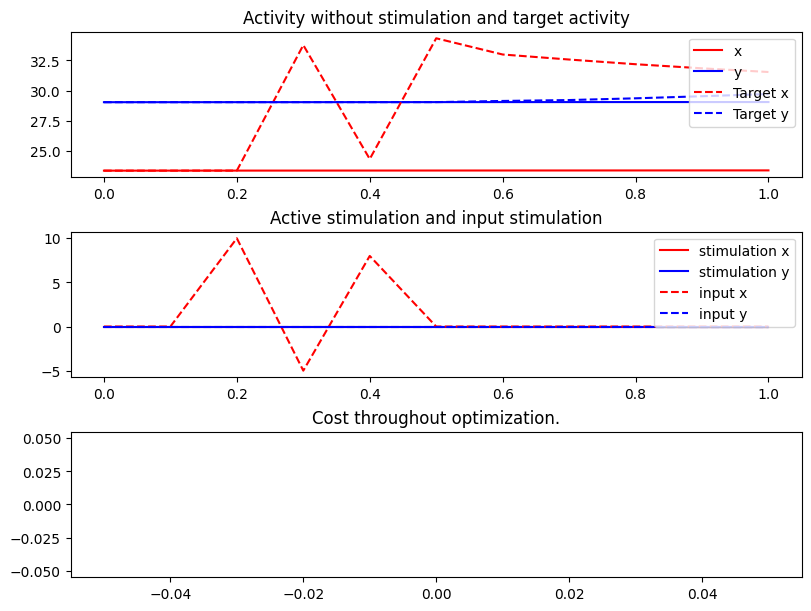

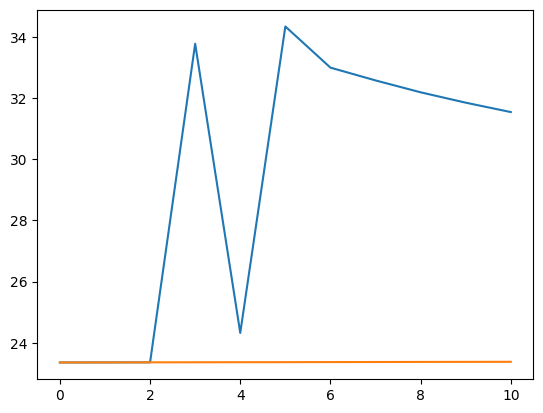

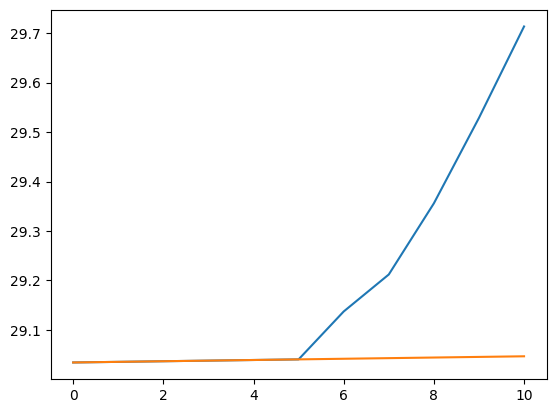

In [4]:
# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.run()

# Define the result of the stimulation as target
t0 = np.concatenate( (model.params["rates_exc_init"][:, np.newaxis, -1], model.params["rates_inh_init"][:, np.newaxis, -1]), axis=1)[:,:,np.newaxis]
t1 = np.stack( (model.rates_exc, model.rates_inh), axis=1)
target = np.concatenate((t0, t1), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
s0 = np.concatenate( (model.params["rates_exc_init"][:, np.newaxis, -1], model.params["rates_inh_init"][:, np.newaxis, -1]), axis=1)[:,:,np.newaxis]
s1 = np.stack( (model.rates_exc, model.rates_inh), axis=1)
state = np.concatenate((s0, s1), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

if True:
    plt.plot(target[0,0,:])
    plt.plot(state[0,0,:])
    #plt.ylim(0.9*state[0,1,-1],1.1*state[0,1,-1])
    plt.show()

if True:
    plt.plot(target[0,1,:])
    plt.plot(state[0,1,:])
    #plt.ylim(0.9*state[0,1,-1],1.1*state[0,1,-1])
    plt.show()

Compute control for a deterministic system
Cost in iteration 0: 31.137158850862633
nan in gradient, break
Final cost : 31.137158850862633


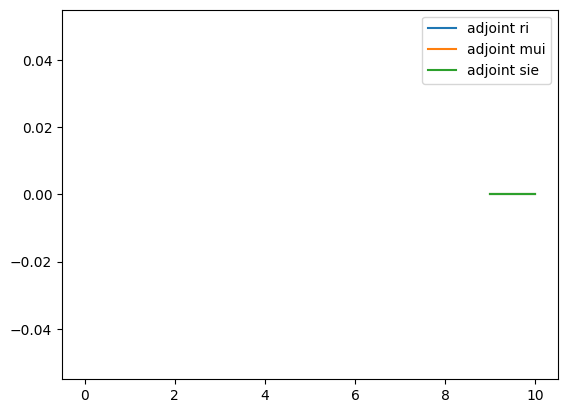

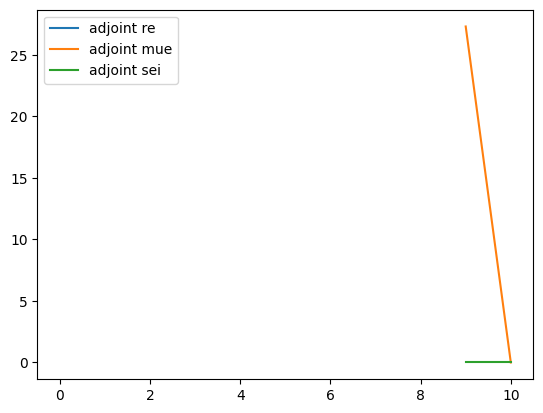

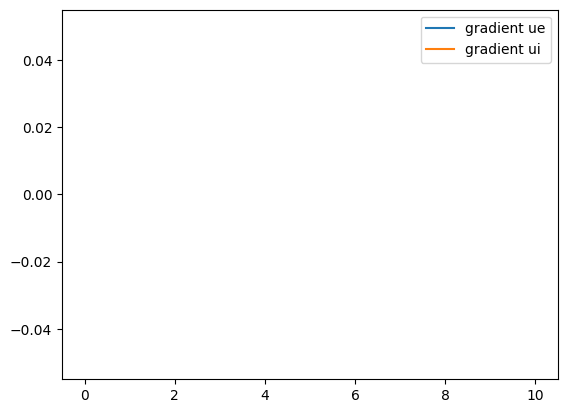

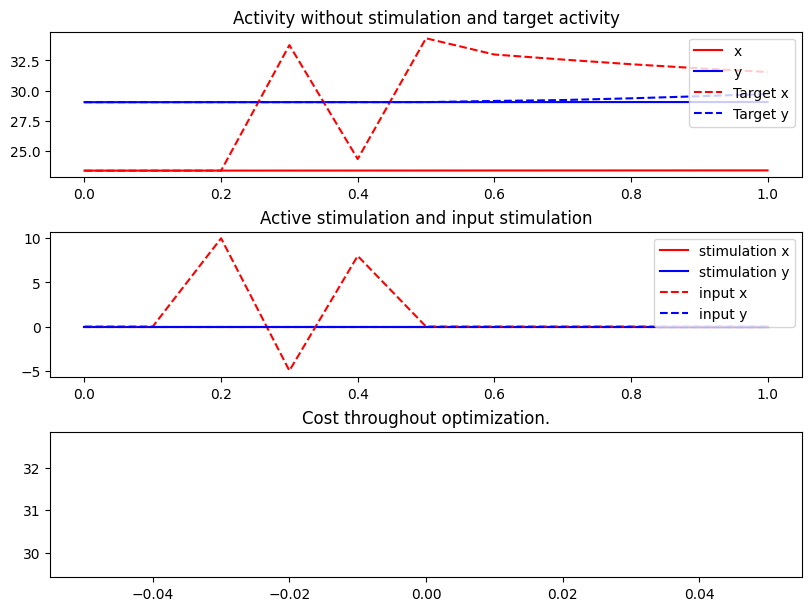

In [5]:
cost_mat = np.zeros((1,2))
cost_mat[0,0] = 1

control_mat = np.zeros((1,2))
control_mat[0,0] = 1

model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,1001,10), cost_matrix = cost_mat, control_matrix=control_mat)
model_controlled.update_input()

model_controlled.optimize(100)

plt.plot(model_controlled.adjoint_state[0,1,:], label="adjoint ri")
plt.plot(model_controlled.adjoint_state[0,3,:], label="adjoint mui")
plt.plot(model_controlled.adjoint_state[0,7,:], label="adjoint sie")
plt.legend()
plt.show()
plt.plot(model_controlled.adjoint_state[0,0,:], label="adjoint re")
plt.plot(model_controlled.adjoint_state[0,2,:], label="adjoint mue")
plt.plot(model_controlled.adjoint_state[0,6,:], label="adjoint sei")

plt.legend()
plt.show()
plt.plot(model_controlled.gradient[0,0,:], label="gradient ue")
plt.plot(model_controlled.gradient[0,1,:], label="gradient ui")
plt.legend()
plt.show()

plot_oc_singlenode(duration, dt, model_controlled.get_xs(), target, model_controlled.control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.2067316356660884
Cost in iteration 100: 0.04502756632029628
Cost in iteration 200: 0.01408346037429517
Cost in iteration 300: 0.005320704962115236
Cost in iteration 400: 0.0021190765332001617
Cost in iteration 500: 0.0008675179815865782
Cost in iteration 600: 0.00036022913499740496
Cost in iteration 700: 0.00015176320937550255
Cost in iteration 800: 6.468509740709789e-05
Cost in iteration 900: 2.7560856707896515e-05
Cost in iteration 1000: 1.1854859175981593e-05
Final cost : 1.1854859175981593e-05


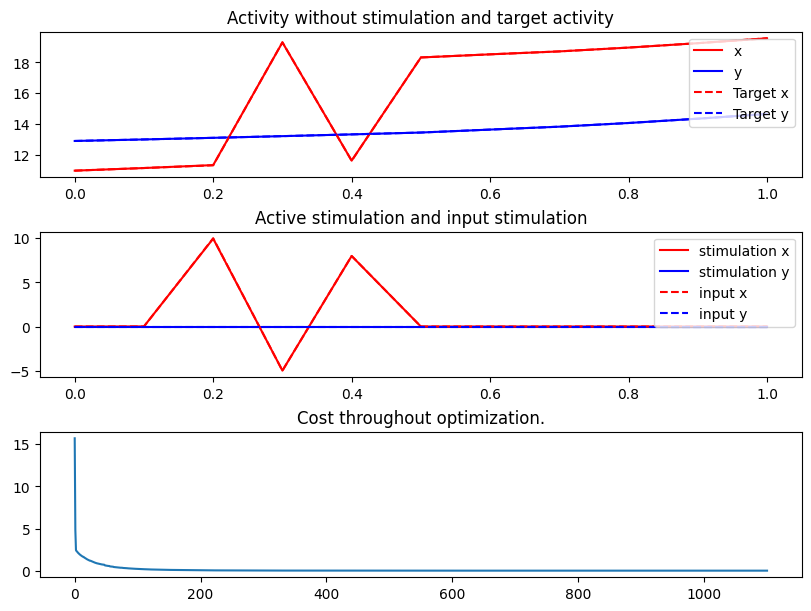

In [6]:
model_controlled.print_array = np.arange(0,10001, 100)
model_controlled.optimize(1000)

if False:
    plt.plot(model_controlled.adjoint_state[0,1,:], label="adjoint ri")
    plt.plot(model_controlled.adjoint_state[0,3,:], label="adjoint mui")
    plt.plot(model_controlled.adjoint_state[0,7,:], label="adjoint sie")
    plt.legend()
    plt.show()
    plt.plot(model_controlled.adjoint_state[0,0,:], label="adjoint re")
    plt.plot(model_controlled.adjoint_state[0,2,:], label="adjoint mue")
    plt.legend()
    plt.show()
    plt.plot(model_controlled.gradient[0,0,:], label="gradient ue")
    plt.plot(model_controlled.gradient[0,1,:], label="gradient ui")
    plt.legend()
    plt.show()

plot_oc_singlenode(duration, dt, model_controlled.get_xs(), target, model_controlled.control, target_input, model_controlled.cost_history)